This script is responsible for augmenting data before augmentations located in dataset_not_splited->annotations_circle and dataset_not_splited->images folders.

Script saves data after augmentation process in dataset_not_splited folder in given by user folders.

There are two separate folders for images and annotations. Data is not splited into subsets.

In [1]:
# Importing used libraries
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
import os
import shutil
import pandas as pd
import cv2
import glob
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Circle

In [2]:
# Loading file paths for raw data before augmentation
path_annotations_circle = r'datasets_not_splited\annotations_circle'
path_images = r'datasets_not_splited\images'

Definition of used functions

In [3]:
# Getting all circular coordinates into one pd.DataFrame
def create_df(path_annotations_circle):
    all_files = glob.glob(path_annotations_circle + "\\*.csv")
    df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
    df_circle = df[['name', 'c-x', 'c-y', 'radius']]

    return df_circle

# Getting all circular boxes coords to one list
def get_bbox_cords(df_circle):
    gb = df_circle.groupby('name')    
    gb = [gb.get_group(x) for x in gb.groups]

    return gb

# Getting all images in list from folder
def get_image_data(imagespath):
  path = glob.glob(imagespath + '\\*.png')
  images=[cv2.imread(file) for file in path]
  return images

# Draw circles on img
def draw_circle(ax, Color, coords):
    for elem in coords:
        # Do not try to draw circles when there is no object
        if str(elem[3]) == 'NaN':
            pass
        else:
            print(elem)
            x = float(elem[1])
            y = float(elem[2])
            radius = float(elem[3])
            circ = Circle((x,y),radius, fill=False, color = Color)
            ax.add_patch(circ)
    return ax

# Plot img with results and original img coords
def plot_results(img, prediction, original_coords):

    # Create a figure. Equal aspect so circles look circular
    fig,ax = plt.subplots(1)
    ax.imshow(img, interpolation='nearest')

    ax = draw_circle(ax, 'Blue', original_coords)

    plt.show()

Defining augmentation techniques that will be used.

There are three definitions:

- seq : techniques specified for first augmentation process without translation,
- seq1 : techniques specified for second augmentation process with translation for images where bboxes are not too close to images boundaries,
- seq2 : techniques specified for second augmentation process without translation for images where bboxes are too close to images boundaries.

All techniques are used randomly.

In [ ]:
# Specify augmentations that will be executed on each image randomly
seq = iaa.Sequential([
    iaa.Fliplr(0.8), # horizontal flips
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.05))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.95, 1.05)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.95, 1.05), per_channel=0.25)],
    random_order=True) # apply augmenters in random order# apply augmenters in random order

In [23]:
seq2 = iaa.Sequential([
    iaa.Fliplr(0.8), 

    # Translation
    iaa.Affine(
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, 
    ),
    iaa.Multiply((0.8, 1.2)), 
    iaa.LinearContrast((0.8, 1.2)), 
    iaa.AdditiveGaussianNoise(scale=0.05*255),
    iaa.GaussianBlur(sigma=(0, 0.05)),
    iaa.WithColorspace(
        to_colorspace="HSV",
        from_colorspace="RGB",
        children=iaa.WithChannels(0, iaa.Add((-10, 10))) 
    )
], random_order=True)

In [24]:
seq1 = iaa.Sequential([
    iaa.Fliplr(0.8), 

    iaa.Multiply((0.8, 1.2)), 
    iaa.LinearContrast((0.8, 1.2)),
    iaa.AdditiveGaussianNoise(scale=0.05*255),
    iaa.GaussianBlur(sigma=(0, 0.05)),
    iaa.WithColorspace(
        to_colorspace="HSV",
        from_colorspace="RGB",
        children=iaa.WithChannels(0, iaa.Add((-10, 10))) 
    )
], random_order=True)

Process of augmentation


In [26]:
# Define number of augmentations per image
# 7 means that for each image there will be seven augmented ones, so there will be 8 images in total
augmentations = 7

# Define min distance for image edge to decide which augmentation techniques will be used
min_distance_from_edge = 32

# Get a list of all images in the folder
img_list = [img for img in os.listdir(path_images) if img.endswith('.png')]

# Load DataFrame with annotations
df = create_df(path_annotations_circle)

gb = df.groupby('name')    
gb = [gb.get_group(x) for x in gb.groups]

In [4]:
# Define paths for saving augmented data
path_annotations_circle_aug = r'datasets_not_splited\annotations_circle_aug2'
path_images_aug = r'datasets_not_splited\images_aug2'

In [27]:
# Augmentation process execution
for filename in img_list:

    # load image
    img = cv2.imread(os.path.join(path_images, filename))
    # create empty list for bounding_boxes
    bbs = []

    # Get df from list with same name as filename
    for i in range(len(gb)):
        if str(gb[i]['name'].values.tolist()[0][:-4]) == str(filename[:-4]):
            df = gb[i].values.tolist()
            
    for row in df:
        r = float(row[3])
        x1 = float(row[1])
        y1 = float(row[2])
        bbs.append(BoundingBox(x1=x1, y1=y1,x2=x1,y2=y1, label=r))

    # concatenate all bounding boxes fro that image
    bbs = BoundingBoxesOnImage(bbs, shape=img.shape[:-1])


    # Check distance to edge
    too_close_to_edge = any(
        bb.x1 < min_distance_from_edge or
        bb.x2 > img.shape[1] - min_distance_from_edge or
        bb.y1 < min_distance_from_edge or
        bb.y2 > img.shape[0] - min_distance_from_edge
        for bb in bbs
    )

    # Decide on augmentation techniques
    seq = seq1 if too_close_to_edge else seq2

    # replicate the image augmentations times
    images = [img for _ in range(augmentations)]
    # replicate the bounding boxes augmentations times
    bbss = [bbs for _ in range(augmentations)]

    # augment images with bounding_boxes
    image_aug, bbs_aug = seq(images=images, bounding_boxes=bbss)
    image_aug.append(img)
    bbs_aug.append(bbs)

    # Save data into folders
    for iter in range(len(bbs_aug)):
        data_c = []
        prefix = f'aug_{str(iter)}'
        for bb in bbs_aug[iter]:
            data = []
            x = float(bb.x1)
            y = float(bb.y1)
            radius = float(bb.label)
            name = filename.replace('.png', f'_{prefix}.csv')
            data.append(name)
            data.append(x)
            data.append(y)
            data.append(radius)
            data_c.append(data)
        data = pd.DataFrame(data_c, columns = ['name','c-x', 'c-y', 'radius'])
        data.to_csv(f'{path_annotations_circle_aug}\\{filename[:-4]}_{prefix}.csv')
        cv2.imwrite(f'{path_images_aug}\\{filename[:-4]}_{prefix}.png',image_aug[iter])
    

In [5]:
# Load data to check if augmentation process was completed with success
df_circle = create_df(path_annotations_circle_aug)
df = get_bbox_cords(df_circle)
img = get_image_data(path_images_aug)

['20130320T004946.285290.Cam6_34_aug_7.csv' 97.1 51.94 23.87]
['20130320T004946.285290.Cam6_34_aug_7.csv' 167.74 47.42 18.38]
['20130320T004946.285290.Cam6_34_aug_7.csv' 199.68 27.1 21.61]
['20130320T004946.285290.Cam6_34_aug_7.csv' 37.1 110.0 19.03]
['20130320T004946.285290.Cam6_34_aug_7.csv' 136.77 173.87 21.61]
['20130320T004946.285290.Cam6_34_aug_7.csv' 298.39 197.1 19.35]


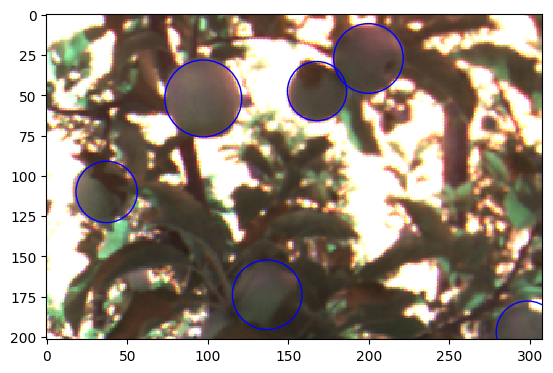

['20130320T012831.094835_24_aug_7.csv' 100.83 188.61 17.59]
['20130320T012831.094835_24_aug_7.csv' 108.33 161.11 15.92]
['20130320T012831.094835_24_aug_7.csv' 136.94 153.89 17.31]
['20130320T012831.094835_24_aug_7.csv' 254.17 164.44 16.2]
['20130320T012831.094835_24_aug_7.csv' 115.28 133.33 17.59]
['20130320T012831.094835_24_aug_7.csv' 119.44 120.28 16.75]
['20130320T012831.094835_24_aug_7.csv' 132.5 93.61 16.75]
['20130320T012831.094835_24_aug_7.csv' 119.17 87.5 16.2]
['20130320T012831.094835_24_aug_7.csv' 149.17 69.44 16.2]
['20130320T012831.094835_24_aug_7.csv' 145.83 24.17 16.2]
['20130320T012831.094835_24_aug_7.csv' 40.0 96.39 15.37]
['20130320T012831.094835_24_aug_7.csv' 8.61 104.17 18.7]


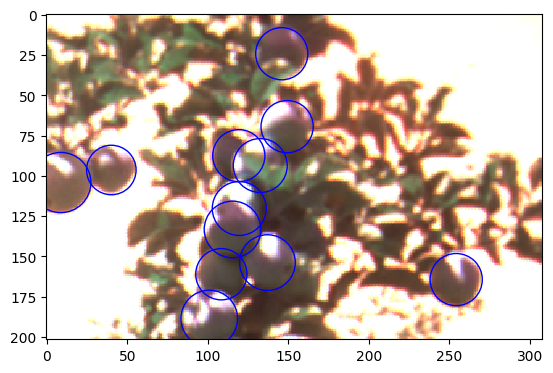

['20130320T005237.526927.Cam6_22_aug_4.csv' 281.29 116.13 20.32]
['20130320T005237.526927.Cam6_22_aug_4.csv' 254.52 126.77 18.06]
['20130320T005237.526927.Cam6_22_aug_4.csv' 203.87 70.32 18.06]


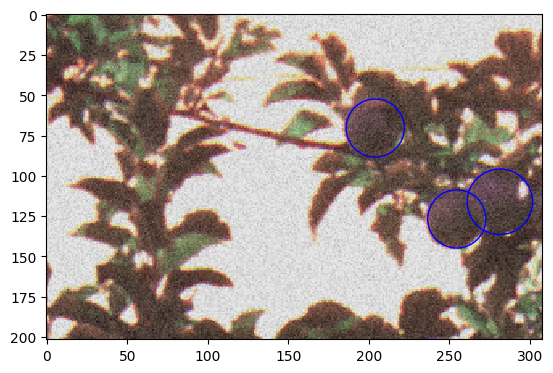

['20130320T005614.102778.Cam6_73_aug_5.csv' 127.8227310180664
 158.26473999023438 14.53]


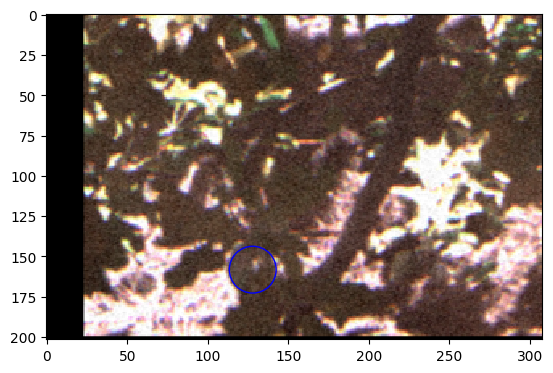

['20130320T004430.659734.Cam6_42_aug_0.csv' 222.66766357421875
 89.22740173339844 19.08]
['20130320T004430.659734.Cam6_42_aug_0.csv' 262.04766845703125
 102.66740417480467 16.89]
['20130320T004430.659734.Cam6_42_aug_0.csv' 245.16766357421875
 73.28739929199219 17.2]
['20130320T004430.659734.Cam6_42_aug_0.csv' 148.607666015625
 142.34739685058594 10.01]


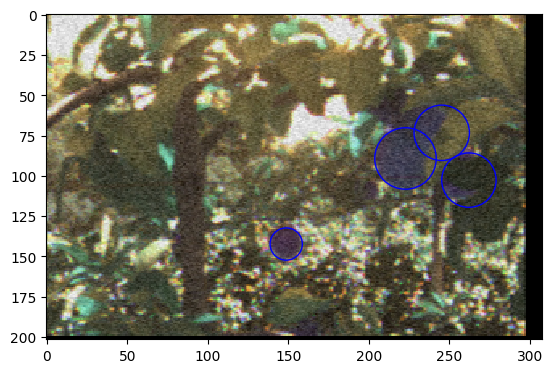

['20130320T004525.136981.Cam6_22_aug_5.csv' nan nan nan]


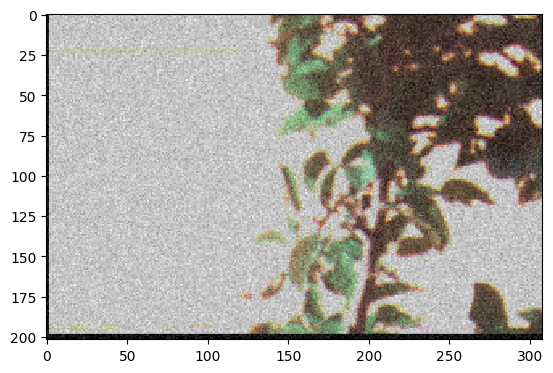

['20130320T004539.042031.Cam6_53_aug_1.csv' nan nan nan]


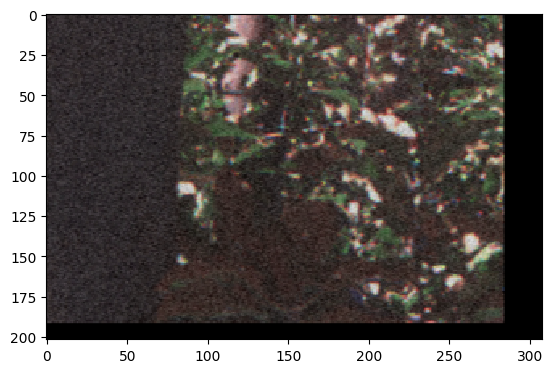

['20130320T004348.182606.Cam6_54_aug_2.csv' nan nan nan]


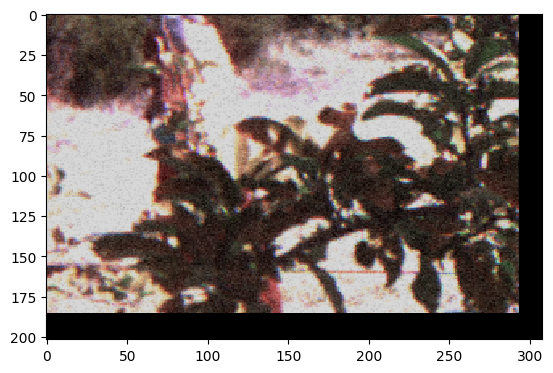

['20130320T004405.706847.Cam6_53_aug_3.csv' 228.1422119140625
 130.55987548828125 16.58]
['20130320T004405.706847.Cam6_53_aug_3.csv' 212.82220458984372
 142.4298858642578 13.14]
['20130320T004405.706847.Cam6_53_aug_3.csv' 205.01220703125
 109.9298858642578 13.14]
['20130320T004405.706847.Cam6_53_aug_3.csv' 180.6422119140625
 138.9998779296875 13.14]
['20130320T004405.706847.Cam6_53_aug_3.csv' 191.57220458984372
 146.17987060546875 13.14]
['20130320T004405.706847.Cam6_53_aug_3.csv' 181.57220458984372
 151.80987548828125 11.26]


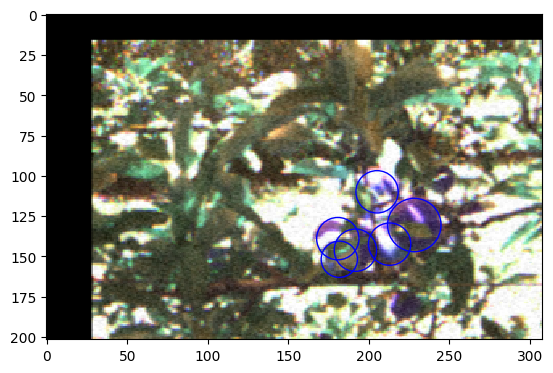

['20130320T004620.376266.Cam6_41_aug_3.csv' 140.41 114.83 12.02]
['20130320T004620.376266.Cam6_41_aug_3.csv' 230.41 174.48 12.02]
['20130320T004620.376266.Cam6_41_aug_3.csv' 184.55 176.21 11.33]
['20130320T004620.376266.Cam6_41_aug_3.csv' 42.48000000000002 170.34 10.64]
['20130320T004620.376266.Cam6_41_aug_3.csv' 19.720000000000027 184.14
 10.64]
['20130320T004620.376266.Cam6_41_aug_3.csv' 55.93000000000001 172.41 10.64]
['20130320T004620.376266.Cam6_41_aug_3.csv' 3.170000000000016 162.76 10.64]
['20130320T004620.376266.Cam6_41_aug_3.csv' 48.339999999999975 142.76 9.61]
['20130320T004620.376266.Cam6_41_aug_3.csv' 248.0 102.41 13.06]


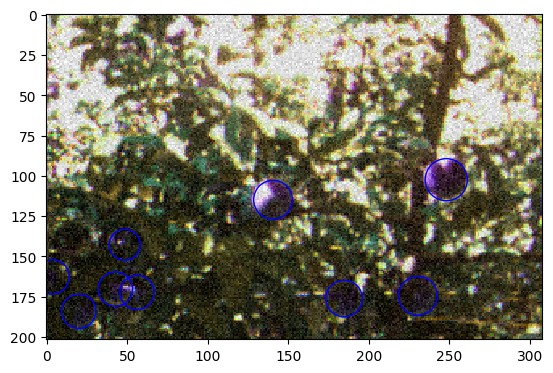

['20130320T004432.755029.Cam6_44_aug_5.csv' 77.72691345214844
 160.99990844726562 8.45]
['20130320T004432.755029.Cam6_44_aug_5.csv' 180.22691345214844
 178.81991577148438 7.51]
['20130320T004432.755029.Cam6_44_aug_5.csv' 170.22691345214844
 186.3199157714844 8.45]
['20130320T004432.755029.Cam6_44_aug_5.csv' 103.66691589355467
 64.12991333007812 10.01]


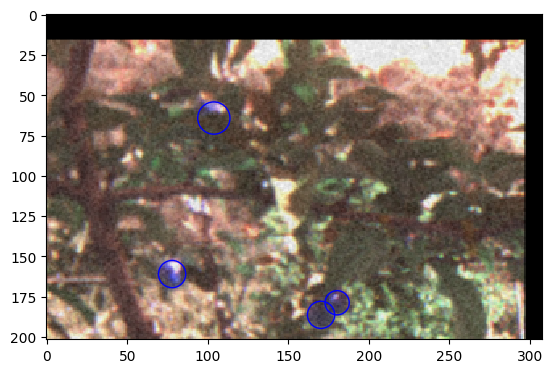

['20130320T004539.042031.Cam6_53_aug_2.csv' nan nan nan]


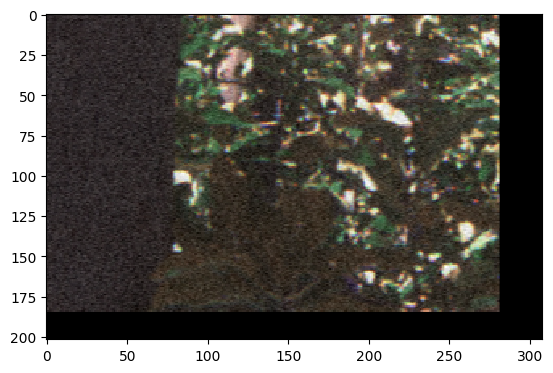

['20130320T004405.706847.Cam6_53_aug_2.csv' 226.14796447753903
 118.45367431640624 16.58]
['20130320T004405.706847.Cam6_53_aug_2.csv' 210.8279571533203
 130.32366943359375 13.14]
['20130320T004405.706847.Cam6_53_aug_2.csv' 203.01795959472656
 97.82367706298828 13.14]
['20130320T004405.706847.Cam6_53_aug_2.csv' 178.64796447753906
 126.8936767578125 13.14]
['20130320T004405.706847.Cam6_53_aug_2.csv' 189.5779571533203
 134.07366943359375 13.14]
['20130320T004405.706847.Cam6_53_aug_2.csv' 179.5779571533203
 139.70367431640625 11.26]


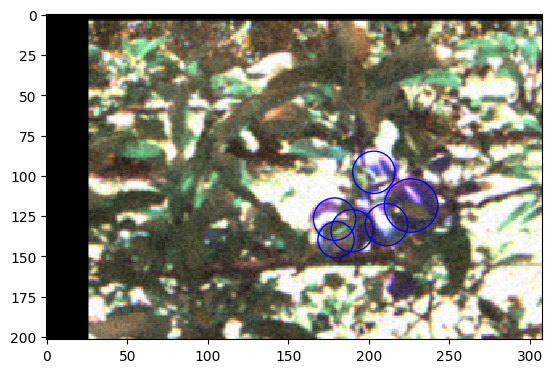

['20130320T004357.135163.Cam6_61_aug_5.csv' nan nan nan]


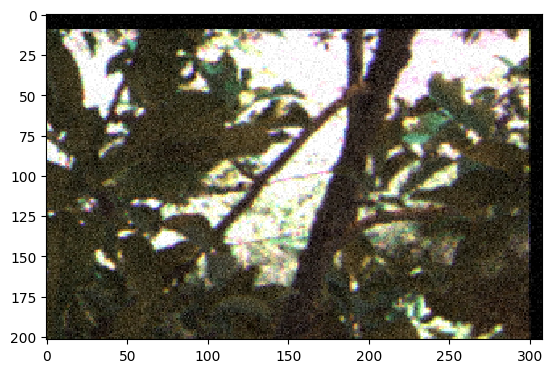

['20130320T004354.849492.Cam6_52_aug_2.csv' 278.12 48.12 11.89]


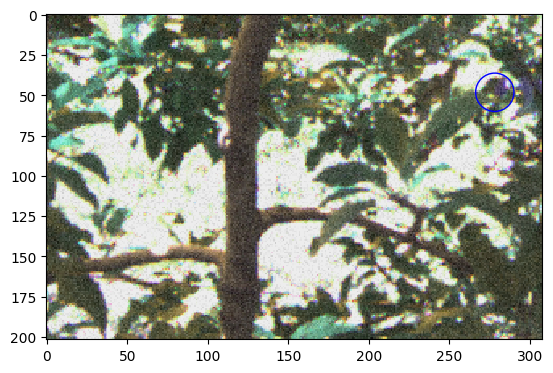

In [17]:
# Definig list of obj to display
l = [2543,6543,3452,4765,504,653,785,2,235,1235,541,786,234,125,98]

# Display objects
for num in l:
    plot_results(img[num], 0, df[num].values)

In [25]:
# Additional block to delete files from folders in case of poorly executed augmentation
for f in os.listdir(path_annotations_circle_aug):
    os.remove(os.path.join(path_annotations_circle_aug, f))

for f in os.listdir(path_images_aug):
    os.remove(os.path.join(path_images_aug, f))